In [41]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, *pool_size, 1]
        padding = padding.upper()
        strides = [1, *strides, 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = pool_size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        mask = K.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3])

        ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                            K.flatten(updates),
                            [K.prod(output_shape)])

        input_shape = updates.shape
        out_shape = [-1,
                     input_shape[1] * self.size[0],
                     input_shape[2] * self.size[1],
                     input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3]
        )

def segnet(input_shape, n_labels, num_filters=32, output_mode="softmax"):
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_1)

    conv_2 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_2)

    conv_3 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_2)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_3)

    conv_4 = Convolution2D(4 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_4)

    unpool_1 = MaxUnpooling2D(pool_size=(2, 2))([pool_4, mask_4])

    conv_5 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)

    unpool_2 = MaxUnpooling2D(pool_size=(2, 2))([conv_5, mask_3])

    conv_6 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)

    unpool_3 = MaxUnpooling2D(pool_size=(2, 2))([conv_6, mask_2])

    conv_7 = Convolution2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    unpool_4 = MaxUnpooling2D(pool_size=(2, 2))([conv_7, mask_1])

    conv_8 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_8 = BatchNormalization()(conv_8)
    outputs = Activation(output_mode)(conv_8)

    segnet = Model(inputs=inputs, outputs=outputs)
    return segnet

In [43]:
#The imports we will all need
from matplotlib import pyplot as plt 
from PIL import Image, ImageOps
import os
import numpy as np
import cv2
from sklearn.metrics import roc_curve, auc, f1_score
import glob


#You may have to remove this import and all the @njit wrappers at the top of each function
#I don't think numba works with collab is why
#If it does, keep it. The preproccessing code will run faster if the wrappers are present
#The preprocessing code will take a bit to run without it... I brute forced everything :/
from numba import njit

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#The original size of the images, leave as is
OG_SIZE = (1000, 1000)

#The size of image that will be put into the NN
NEW_SIZE = (512, 512)

#Resizing flag. If true resizing will be used to make input of size NEW_SIZE
#If false, padding is added on the left and bottom sides of image to make input of size NEW_SIZE
#if using padding, you can only increase dims of OG_SIZE.
RESIZE = True

#The interpolation method for when you want to resize (.tiff and np.arrays will only work with INTER_NEAREST)
interp = cv2.INTER_NEAREST

#How many times to split up the image for the NN
#Only need to use this if having memory troubles
#Will turn 1 (1024,1024) image into 4 (512,512) images for DIV = 2 (or 16 (256,256) for DIV=4 and so on)
DIV = 1


#Scales all input images between 0 and 1
def Scale(arr):
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return arr


#Reserve the space for all inputs and outputs
train_imgs = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_imgs = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_imgs = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))

train_masks = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_masks = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_masks = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))

tr = 0
va = 0
te = 0

path = '/content/drive/MyDrive/Images/'

#Goes into Images folder in same folder as this .ipynb and extracts neccesary data
#Make sure you have this folder downloaded the same way as the GitHub 'Images' folder I posted
for folder in os.listdir(path):
    for image in sorted(glob.glob(path + folder + '/*.tif')):
        identifier = image[len(image)-8:len(image)-4]
            
        img = Image.open(image)
            
        if folder == 'data_trainset':
            if identifier == 'mask':
                if RESIZE:
                    train_masks[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    tr += 1
                else:
                    train_masks[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    tr += 1
            else:
                if RESIZE:
                    train_imgs[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    train_imgs[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                    
                    
        elif folder == 'data_validset':
            if identifier == 'mask':
                if RESIZE:
                    valid_masks[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    va += 1
                else:
                    valid_masks[va,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    va += 1
            else:
                if RESIZE:
                    valid_imgs[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    valid_imgs[va,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                
                
        elif folder == 'data_testset':
            if identifier == 'mask':
                if RESIZE:
                    test_masks[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    te += 1
                else:
                    test_masks[te,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    te += 1
            else:
                if RESIZE:
                    test_imgs[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    test_imgs[te,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))

In [45]:
#Only really needed if memory problems,
#Keep in code tho
#If DIV is set to 1 it will work how you guys need it
@njit
def ReshapeX(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div)))
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                out[oc,:,:] = img[d1*int(arr.shape[1]/div):(d1+1)*int(arr.shape[1]/div), d2*int(arr.shape[2]/div):(d2+1)*int(arr.shape[2]/div)]
                oc += 1
    return out

X_train = ReshapeX(train_imgs, DIV)
X_valid = ReshapeX(valid_imgs, DIV)
X_test = ReshapeX(test_imgs, DIV)

#Adds an extra dimension, neccesary for keras formatting
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

#puts Y data into 1 hot encoded formatting for keras
@njit
def OHE(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div), 2, 1))
    
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                pc = 0
                ic = 0
                for i in range(d1*int(arr.shape[1]/div),(d1+1)*int(arr.shape[1]/div)):
                    jc = 0
                    for j in range(d2*int(arr.shape[2]/div),(d2+1)*int(arr.shape[2]/div)):
                        value = img[i,j]
                        if int(value) == 0:
                            out[oc,ic,jc,:] = np.array([[1], [0]]) #No fracture
                        if int(value) == 1:
                            out[oc,ic,jc,:] = np.array([[0], [1]]) #Fracture
                        pc += 1
                        jc += 1
                    ic += 1
                oc += 1
    return out

Y_train = OHE(train_masks,DIV)
Y_valid = OHE(valid_masks,DIV)
Y_test = OHE(test_masks,DIV)

#Adds weight to samples for loss funtion
#since there are so few fracture pixels compared to no fracture
#it helps to add additional weight in our loss function to the fracture class
#Right now fractures are weighted 3x as much as no fracture
#If you don't wanna use it, dont pass it through your fit funtion
@njit
def SampleWeight(arr):
    ws = np.ones((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[0,0] == 0:
                    ws[b,i,j] = 2.5 #Change this number to set the fracture weight
    return ws

sample_weight_train = SampleWeight(Y_train)
sample_weight_valid = SampleWeight(Y_valid)

In [46]:
#Instantiate the model, compile the model, and train the model
#several parameters of this step will need customization depending of the model

#Take note of the input_shape... you will need that
model = segnet(input_shape = (int(NEW_SIZE[0]/DIV), int(NEW_SIZE[1]/DIV), 1), n_labels = 2, output_mode="softmax", num_filters=32)

loss = tf.keras.losses.BinaryCrossentropy()

#Learning rate was tuned for my specific model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss=loss, optimizer=optimizer, metrics=['categorical_accuracy'])

#Stop training when validation loss is at minimum and restore weights from that epoch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

#Arbitrarily high epochs to ensure callback is found
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid, sample_weight_valid), epochs=10000, verbose=1, batch_size=2, sample_weight=sample_weight_train, callbacks=[callback])

Epoch 1/10000
13/13 [==============================] - 2s 78ms/step - loss: 0.7012 - categorical_accuracy: 0.9519 - val_loss: 23.1462 - val_categorical_accuracy: 0.8907
Epoch 2/10000
13/13 [==============================] - 1s 48ms/step - loss: 0.6269 - categorical_accuracy: 0.9780 - val_loss: 0.5763 - val_categorical_accuracy: 0.9799
Epoch 3/10000
13/13 [==============================] - 1s 47ms/step - loss: 0.5676 - categorical_accuracy: 0.9882 - val_loss: 0.5168 - val_categorical_accuracy: 0.9946
Epoch 4/10000
13/13 [==============================] - 1s 47ms/step - loss: 0.5187 - categorical_accuracy: 0.9899 - val_loss: 0.4763 - val_categorical_accuracy: 0.9946
Epoch 5/10000
13/13 [==============================] - 1s 48ms/step - loss: 0.4730 - categorical_accuracy: 0.9915 - val_loss: 0.4387 - val_categorical_accuracy: 0.9941
Epoch 6/10000
13/13 [==============================] - 1s 48ms/step - loss: 0.4321 - categorical_accuracy: 0.9918 - val_loss: 0.4039 - val_categorical_accuracy

In [47]:
#Undo reshape I used for memory and take argmax of results (Just takes argmax if DIV = 1)
#arg_arg true or false if you want argmax or not, respectively
def preds2imgs(arr, div, arg_arg):
    if arg_arg:
        temp = np.argmax(arr, axis=3)
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div)))
    else:
        temp = arr
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div),2))
        
    tc = 0
    for img in range(int((arr.shape[0])/(div**2))):
        for d1 in range(div):
            for d2 in range(div):
                if arg_arg:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1])] = temp[tc]
                    tc += 1
                else:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1]),:] = temp[tc]
                    tc += 1
    return out


#Show loss and accuracy of all datasets from epoch of restored weights
acc_train = model.evaluate(X_train, Y_train, verbose=0, batch_size=1)
print(" Train loss: ", acc_train[0], " Train accuracy: ", acc_train[1])
acc_valid = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=1)
print(" Valid loss: ", acc_valid[0], " Valid accuracy: ", acc_valid[1])
acc_test = model.evaluate(X_test, Y_test, verbose=0, batch_size=1)
print(" Test loss: ", acc_test[0], " Test accuracy: ", acc_test[1])

#predict your results
valid_results = model.predict(X_valid, batch_size=1)
test_results = model.predict(X_test, batch_size=1)

valid_argmax_pred = preds2imgs(valid_results, DIV, True)
valid_argmax_true = preds2imgs(np.squeeze(Y_valid, axis = 4), DIV, True)

test_argmax_pred = preds2imgs(test_results, DIV, True)
test_argmax_true = preds2imgs(np.squeeze(Y_test, axis = 4), DIV, True)

# #Plot accuracies from training
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# #Plot losses from training
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


#Resizes or removes padding from argmax results depending on which you used.
def ToOGSize(arr, num_images, RESIZE, OG_SIZE, interp):
    OG = np.zeros((num_images,OG_SIZE[0],OG_SIZE[1]))
    for i in range(num_images):
        if RESIZE:
            OG[i,:,:] = cv2.resize(arr[i], OG_SIZE, interpolation=interp)
        else:
            OG[i,:,:] = arr[i,0:OG_SIZE[0],0:OG_SIZE[1]]
    return OG

valid_argmax_pred_OG = ToOGSize(valid_argmax_pred,
                                6, RESIZE,
                                OG_SIZE, interp)
valid_argmax_true_OG = ToOGSize(valid_argmax_true,
                                6, RESIZE,
                                OG_SIZE, interp)

test_argmax_pred_OG = ToOGSize(test_argmax_pred,
                               6, RESIZE,
                               OG_SIZE, interp)

test_argmax_true_OG = ToOGSize(test_argmax_true,
                               6, RESIZE,
                               OG_SIZE, interp)

 Train loss:  0.033580198884010315  Train accuracy:  0.9938480854034424
 Valid loss:  0.0323663093149662  Valid accuracy:  0.9946638941764832
 Test loss:  0.05362885072827339  Test accuracy:  0.9875240325927734


(1000, 1000)


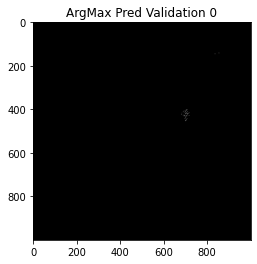

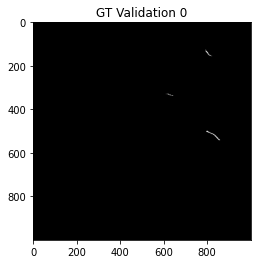

(1000, 1000)


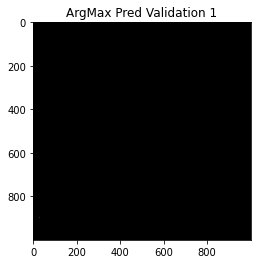

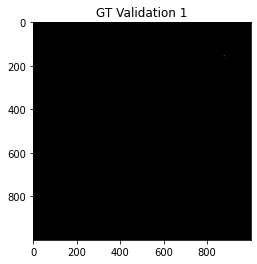

(1000, 1000)


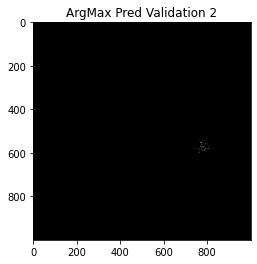

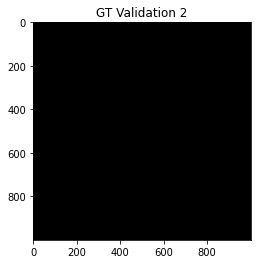

(1000, 1000)


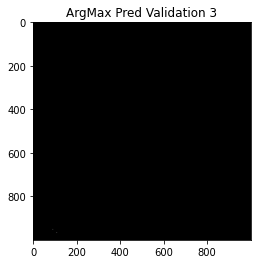

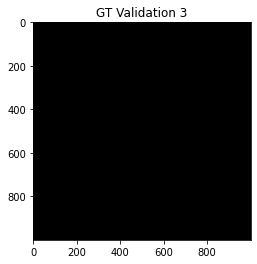

(1000, 1000)


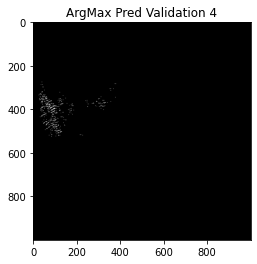

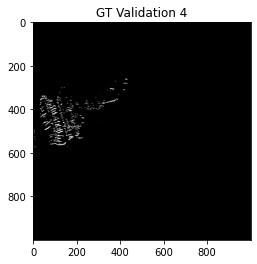

(1000, 1000)


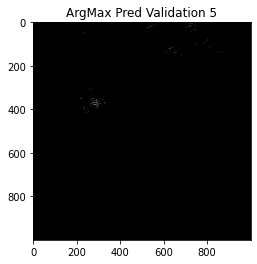

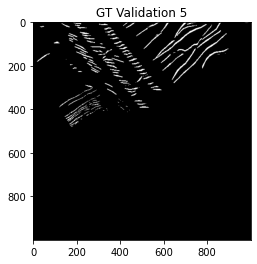

In [48]:
#Plot argmax results for validation data and GT
for i, pred in enumerate(valid_argmax_pred_OG):
    print(pred.shape)
    plt.imshow(pred,cmap='binary_r')
    plt.title("ArgMax Pred Validation "+ str(i))
    plt.show()
    plt.imshow(valid_argmax_true_OG[i], cmap='binary_r')
    plt.title("GT Validation "+ str(i))
    plt.show()

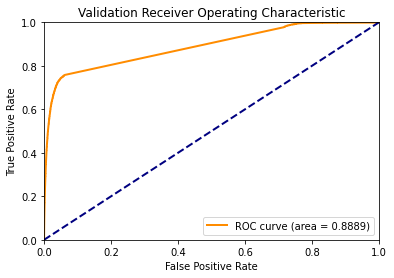

AUC =  0.8888833332055739


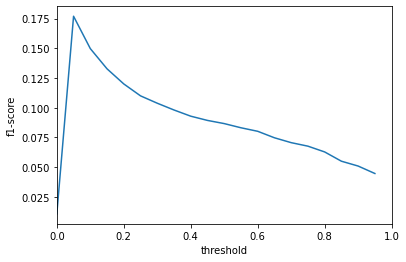

0.12588671959459655


In [53]:
#Formats the data as neccesary to use sklearn roc_curve function
def ToROC(arr, arr_pred):
    out = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    out_pred = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    c = 0
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] == 1:
                    out[c] = 1
                
                out_pred[c] = arr_pred[b,i,j,1]
                c += 1
    return out, out_pred

temp_Y_valid_OG = Y_valid.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_valid_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

temp_valid_results_OG = valid_results.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2)
valid_results_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(6):
        temp_OG_0 = cv2.resize(temp_Y_valid_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_valid_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_valid_OG[i,:,:,0,0] = temp_OG_0
        Y_valid_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_valid_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_valid_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        
        valid_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        valid_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_valid_OG = temp_Y_valid_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    valid_results_OG = temp_valid_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]

#Generates the ROC curve and solves the AUC
valid_roc_true, valid_roc_pred = ToROC(np.squeeze(Y_valid_OG, axis=4), valid_results_OG)
fpr, tpr, thresholds = roc_curve(valid_roc_true, valid_roc_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

#Plot ROC curve and print AUC score
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)


#Determine the fracture threshold best suitable for maximizing f1-score based on validation data
f1 = []
spacing = 0.05
thr = np.arange(0,1,spacing)
for i in thr:
    f1.append(f1_score(valid_roc_true, (valid_roc_pred > i)))

#saves value of best threshold
threshold = np.argmax(f1)*spacing

#Plots the f1-score as a function of threshold values
plt.figure()
plt.plot(thr, f1)
plt.xlim([0,1])
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.show()

print(np.interp(0.1769950200412972, thr, f1))

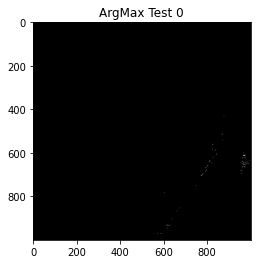

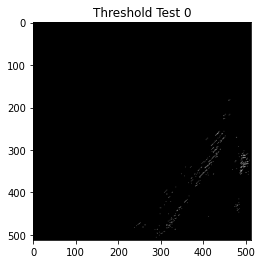

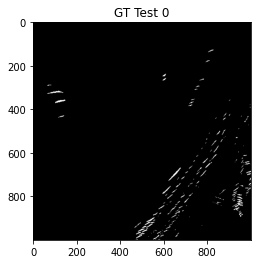

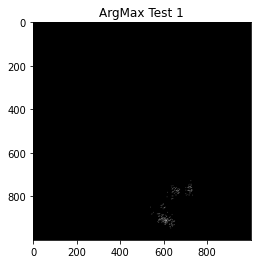

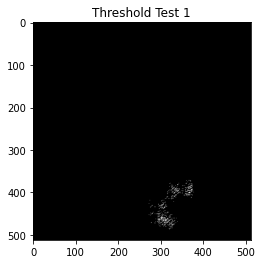

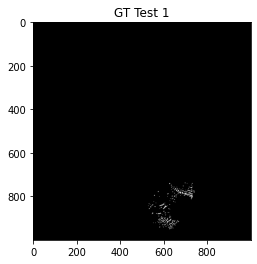

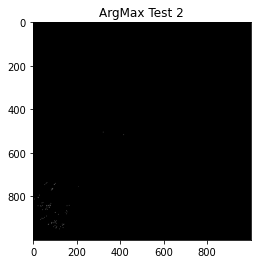

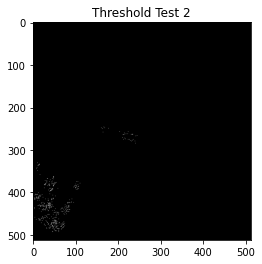

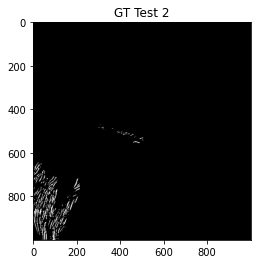

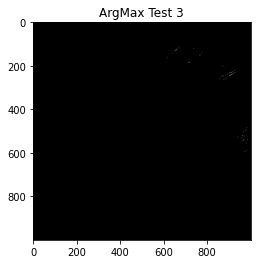

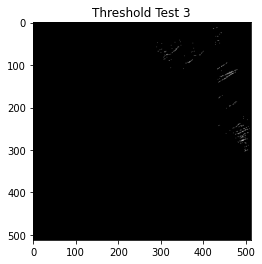

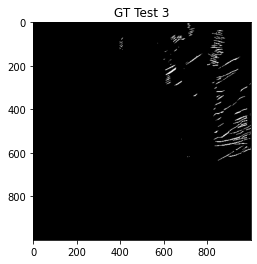

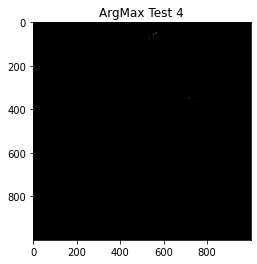

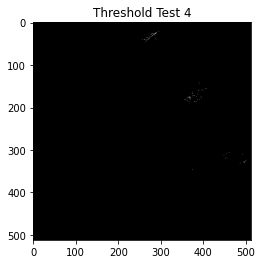

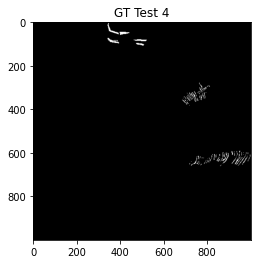

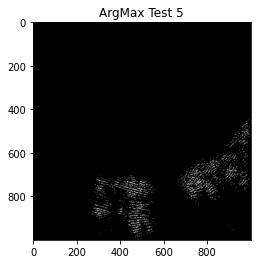

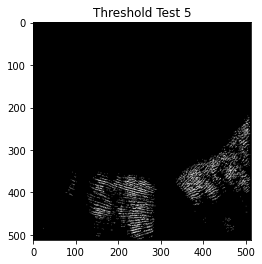

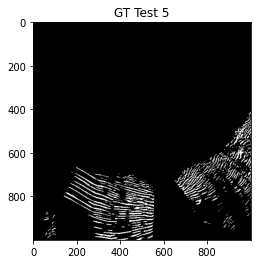

Threshold Test F1-score =  0.3582730797443152


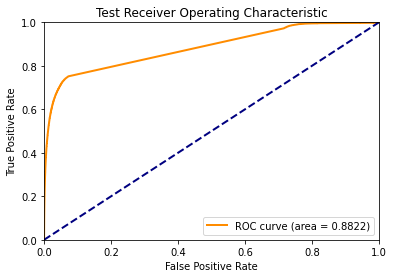

Raw Preds Test AUC =  0.8822442593155493


In [54]:
#Applies threshold found previously to test results

def ApplyThreshold(arr, thr):
    out = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] >= thr:
                    out[b,i,j] = 1
    return out

test_pred_thr = ApplyThreshold(preds2imgs(test_results, DIV, False), threshold)

#Reshapes raw test probability results as neccesary for plotting.
temp_Y_test_OG = Y_test.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_test_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

temp_test_results_OG = test_results.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2)
test_results_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(6):
        temp_OG_0 = cv2.resize(temp_Y_test_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_test_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_test_OG[i,:,:,0,0] = temp_OG_0
        Y_test_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_test_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_test_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        
        test_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        test_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_test_OG = temp_Y_test_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    test_results_OG = temp_test_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]
        
#Plot the raw output of fractures, the ArgMax results, the Threshold applied results, and the Ground truths
for i in range(6):
#     plt.imshow(test_results_OG[i,:,:,1],cmap='binary') #Show if you use softmax activation
#     plt.title("Pred Fracture Value Test "+ str(i))
#     plt.show()
    plt.imshow(test_argmax_pred_OG[i],cmap='binary_r')
    plt.title("ArgMax Test "+ str(i))
    plt.show()
    plt.imshow(test_pred_thr[i,0:OG_SIZE[0],0:OG_SIZE[1]],cmap='binary_r')
    plt.title("Threshold Test "+ str(i))
    plt.show()
    plt.imshow(test_argmax_true_OG[i], cmap='binary_r')
    plt.title("GT Test "+ str(i))
    plt.show()


#Solve the ROC curve and AUC for test data
roc_true_Y, roc_pred_Y = ToROC(np.squeeze(Y_test_OG, axis=4), test_results_OG)
# fpr, tpr, thresholds = roc_curve(roc_true_Y, (roc_pred_Y > threshold), pos_label=1)
# roc_auc = auc(fpr, tpr)

# #Plot the ROC curve, print AUC, and print F1-score score for test data
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('Threshold Test AUC = ',roc_auc)
print('Threshold Test F1-score = ', f1_score(roc_true_Y, (roc_pred_Y > threshold)))


# fpr, tpr, thresholds = roc_curve(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten(), pos_label=1)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('ArgMax Test AUC = ',roc_auc)
# print('ArgMax Test F1-score = ', f1_score(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten()))


fpr, tpr, thresholds = roc_curve(Y_test_OG[:,:,:,1].flatten(), test_results_OG[:,:,:,1].flatten(), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('Raw Preds Test AUC = ',roc_auc)

Text(0.5, 1.0, 'Prediction with an applied threshold')

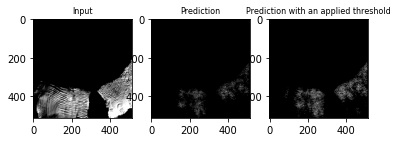

In [92]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(test_imgs[5], cmap='binary_r')
axarr[0].set_title("Input", fontsize=8)
axarr[1].imshow(test_argmax_pred[5],cmap='binary_r')
axarr[1].set_title("Prediction", fontsize=8)
axarr[2].imshow(test_pred_thr[5],cmap='binary_r')
axarr[2].set_title("Prediction with an applied threshold", fontsize=8)